In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import os
import joblib
import lightgbm as lgb
import shap
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import IsolationForest

from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             classification_report,
                             roc_auc_score,
                             roc_curve)
from sklearn.utils import class_weight

os.chdir('/content/drive/MyDrive/12GO/src')
data = pd.read_csv('../data/data.csv')

data.sort_values(by = ['bid', 'createdon'], ascending = [True, True], inplace = True)
data.drop_duplicates(inplace = True)
data = data[data['netprice_thb'] >= 0]

features = ['email_domain_score',
            'email_score',
            'insurance_flg',
            'p_attempts',
            'proxy',
            'recent_abuse',
            'tor',
            'vpn',
            'seats',
            'vehclass_id',
            'passenger_passport_score',
            'passenger_score',
            'payer_country',
            'role_id',
            'channel',
            'nationality',
            'netprice_thb',
            'isFraud']
data = data[features]

cat_cols = ['nationality', 'channel', 'role_id', 'payer_country', 'vehclass_id']
mapping_dicts = {}

for col in cat_cols:
    le = LabelEncoder()
    data[col] = data[col].astype(str)
    data[col] = le.fit_transform(data[col])
    mapping_dicts[col] = dict(zip(le.classes_, le.transform(le.classes_)))


In [ ]:
def get_param_grid(model_name, gpu_enabled=False):
    if model_name == 'lgb':
        return {
            'n_estimators': [50, 100, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    elif model_name == 'xgb':
        return {
            'n_estimators': [50, 100, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'tree_method': ['gpu_hist'] if gpu_enabled else ['auto']
        }
    elif model_name == 'rf':
        return {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    elif model_name == 'if':
        return {
            'n_estimators': [50, 100, 200],
            'max_samples': ['auto', 0.5, 0.75],
            'contamination': [0.01, 0.05, 0.1],
            'max_features': [1.0, 0.8, 0.5]
        }
    elif model_name == 'hgb':
        return {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_iter': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'l2_regularization': [0.0, 0.1, 0.5]
        }
    else:
        return {}

def get_model(model_name, gpu_enabled=False):
    if model_name == 'lgb':
        return lgb.LGBMClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'xgb':
        import xgboost as xgb
        return xgb.XGBClassifier(n_jobs=-1, random_state=42, tree_method='gpu_hist' if gpu_enabled else 'auto')
    elif model_name == 'rf':
        return RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'if':
        return IsolationForest(random_state=42)
    elif model_name == 'hgb':
        return HistGradientBoostingClassifier(random_state=42)
    else:
        return None

def split_and_scale(data,
                    target_col = 'isFraud',
                    test_size  = 0.3,
                    random_state = 42):
    X = data.drop(target_col, axis = 1).to_numpy()
    y = data[target_col].to_numpy()

    positive_weight = len(data) / data[target_col].value_counts()[1]
    negative_weight = len(data) / data[target_col].value_counts()[0]

    data['sample_weight'] = data[target_col].apply(lambda x: positive_weight if x == 1 else negative_weight)

    sample_weight = data['sample_weight'].to_numpy()

    X_train, X_test, y_train, y_test, sample_weight_train, sample_weight_test = train_test_split(
        X, y, sample_weight, test_size=test_size, random_state=random_state, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, sample_weight_train, sample_weight_test, scaler

def train_model(model,
                param_grid,
                X_train,
                y_train,
                sample_weight_train,
                cv = None,
                scoring = 'f1',
                n_iter = 10,
                random_state = 42,
                n_jobs = -1,
                model_name = 'xgb'):
    if cv is None:
        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)

    if model_name == 'if':
        scoring = 'neg_log_loss'

    random_search = RandomizedSearchCV(
        estimator = model,
        param_distributions = param_grid,
        cv = cv,
        n_iter = n_iter,
        scoring = scoring,
        random_state = random_state,
        n_jobs = n_jobs
    )
    random_search.fit(X_train, y_train, sample_weight=sample_weight_train)
    print('Best parameters:', random_search.best_params_)
    print('Best CV score ({}):'.format(scoring), random_search.best_score_)
    best_model = random_search.best_estimator_
    joblib.dump(best_model, f'/content/drive/MyDrive/12GO/results/model/{model_name}.pkl')
    return random_search

def evaluate_model(model, X_test, y_test, class_names=['No Fraud', 'Fraud'], show_plot=False):
    y_pred = model.predict(X_test)

    if -1 in y_pred:
        y_pred = np.where(y_pred == -1, 1, 0)
    y_pred_proba = None

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        if hasattr(model, 'decision_function'):
          y_pred_proba = model.decision_function(X_test)
          auc = roc_auc_score(y_test, y_pred)
    if y_pred_proba is not None:
        conf = confusion_matrix(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred, target_names=class_names)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

        print('Accuracy Score:', np.round(acc, 3))
        print('Confusion Matrix:\n', conf)
        print('Classification Report:\n', clf_report)
        print('AUC ROC Score:', np.round(auc, 3))

        if show_plot:
            plt.figure(figsize=(7, 5))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.show()


In [ ]:
X_train, X_test, y_train, y_test, sample_weight_train, sample_weight_test, scaler = split_and_scale(data)

In [ ]:
model_name = 'hgb'
param_grid = get_param_grid(model_name, gpu_enabled = False)
model = get_model(model_name, gpu_enabled = False)
best_model = train_model(model, param_grid, X_train, y_train, sample_weight_train, model_name = model_name)
evaluate_model(best_model, X_test, y_test)

Accuracy Score: 0.941
Confusion Matrix:
 [[975982  60914]
 [   356   1991]]
Classification Report:
               precision    recall  f1-score   support

    No Fraud       1.00      0.94      0.97   1036896
       Fraud       0.03      0.85      0.06      2347

    accuracy                           0.94   1039243
   macro avg       0.52      0.89      0.52   1039243
weighted avg       1.00      0.94      0.97   1039243

AUC ROC Score: 0.957


The HistGradientBoostingClassifier model achieved a high overall accuracy of 94.1% and an impressive AUC ROC score of 0.957, indicating its strong ability to distinguish between fraudulent and non-fraudulent transactions. However, a closer look at the classification report reveals a critical issue with its performance on the minority class (fraud). While the model boasts a high recall of 85% for fraud detection, its precision is alarmingly low at only 3%. This means that while the model correctly identifies a large portion of actual fraud cases, it also generates a significant number of false positives, mistakenly classifying legitimate transactions as fraudulent. Consequently, the F1-score for fraud is only 6%, reflecting the imbalance between precision and recall. Despite its high overall accuracy, the model's practical effectiveness for fraud detection is hampered by its tendency to raise false alarms, requiring further refinement to improve its precision and reduce the rate of false positives.

In [ ]:
model_name = 'xgb'
param_grid = get_param_grid(model_name, gpu_enabled = False)
model = get_model(model_name, gpu_enabled = False)
best_model = train_model(model, param_grid, X_train, y_train, sample_weight_train, model_name = model_name)
evaluate_model(best_model, X_test, y_test, class_names = ['Fraud', 'No Fraud'])

Best parameters: {'tree_method': 'auto', 'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best CV score (f1): 0.05741439771030325
Accuracy Score: 0.935
Confusion Matrix:
 [[969364  67532]
 [   354   1993]]
Classification Report:
               precision    recall  f1-score   support

       Fraud       1.00      0.93      0.97   1036896
    No Fraud       0.03      0.85      0.06      2347

    accuracy                           0.93   1039243
   macro avg       0.51      0.89      0.51   1039243
weighted avg       1.00      0.93      0.96   1039243

AUC ROC Score: 0.955


XGBoost demonstrates a slightly lower overall accuracy of 93.5% compared to the Gradient Boosting's 94.1%. Its AUC ROC score is also slightly lower at 0.955, indicating a marginally reduced ability to discriminate between fraudulent and non-fraudulent transactions. However, like the Gradient Boosting, XGBoost exhibits a similar pattern of imbalanced performance on the fraud class. While it achieves a high recall of 85% for fraud detection, its precision remains low at 3%, suggesting that while it successfully identifies a significant portion of actual fraud cases, it also triggers a substantial number of false positives. As a result, the F1-score for fraud is only 6%, mirroring the trade-off between precision and recall observed in Gradient Boosting.

Both XGBoost and Gradient Boosting exhibit similar performance characteristics, particularly in their struggle to achieve high precision for fraud detection. While Gradient Boosting achieves slightly higher overall accuracy and AUC ROC score, the difference is marginal. Both models prioritize recall over precision for the fraud class, leading to a high number of false positives. This behavior likely stems from the inherent imbalance in the dataset, where fraudulent transactions are significantly less frequent than legitimate ones.

In [ ]:
model_name = 'if'
param_grid = get_param_grid(model_name, gpu_enabled = False)
model = get_model(model_name, gpu_enabled = False)
best_model = train_model(model, param_grid, X_train, y_train, sample_weight_train, model_name = model_name)
evaluate_model(best_model, X_test, y_test)

Accuracy Score: 0.95
Confusion Matrix:
 [[985818  51078]
 [  1323   1024]]
Classification Report:
               precision    recall  f1-score   support

    No Fraud       1.00      0.95      0.97   1036896
       Fraud       0.02      0.44      0.04      2347

    accuracy                           0.95   1039243
   macro avg       0.51      0.69      0.51   1039243
weighted avg       1.00      0.95      0.97   1039243

AUC ROC Score: 0.694


Lower AUC ROC score of the Isolation Forest suggests that it is less effective in discriminating between fraudulent and non-fraudulent transactions compared to the other two models. An AUC ROC score close to 0.5 indicates a model performing similarly to random guessing, while scores closer to 1 represent better discrimination ability. In this case, the IF model's AUC ROC score of 0.694 indicates that it performs better than random guessing but is considerably less accurate than HistGradientBoostingClassifier and XGBoost in distinguishing fraudulent transactions.

In [ ]:
model_name = 'lgb'
param_grid = get_param_grid(model_name, gpu_enabled = False)
model = get_model(model_name, gpu_enabled = False)
best_model = train_model(model, param_grid, X_train, y_train, sample_weight_train, model_name = model_name)
evaluate_model(best_model, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy Score: 0.935
Confusion Matrix:
 [[969742  67154]
 [   352   1995]]
Classification Report:
               precision    recall  f1-score   support

    No Fraud       1.00      0.94      0.97   1036896
       Fraud       0.03      0.85      0.06      2347

    accuracy                           0.94   1039243
   macro avg       0.51      0.89      0.51   1039243
weighted avg       1.00      0.94      0.96   1039243

AUC ROC Score: 0.955


LightGBM, with an overall accuracy of 93.5%, demonstrates a similar performance pattern to the other models tested. A deep dive into its confusion matrix reveals the model's strength in correctly identifying the majority class – the non-fraudulent transactions, achieving 969,742 true negatives. However, this success is counterbalanced by a significant number of false positives, with 67,154 legitimate transactions mistakenly flagged as fraudulent. This translates into a low precision of only 3% for the fraud class. While the model boasts a high recall of 85%, successfully capturing most actual fraud cases (1,995 true positives), it does so at the expense of raising numerous false alarms. This trade-off highlights the inherent challenge of fraud detection in imbalanced datasets where prioritizing recall – catching as many fraud cases as possible – often results in lower precision and more false positives. While LightGBM performs well in identifying potential fraud, its current configuration might trigger unnecessary investigations and potentially impact customer experience.

# Model Performance
In this analysis, four machine learning models—HistGradientBoostingClassifier, XGBoost, Isolation Forest, and LightGBM—were evaluated for their performance in fraud detection using a transactional dataset. HistGradientBoostingClassifier emerged as the most promising model, achieving the highest accuracy (94.1%) and AUC ROC score (0.957). XGBoost and LightGBM demonstrated comparable performance, with only marginal differences in accuracy and recall. Isolation Forest, however, exhibited a considerably lower AUC ROC score, indicating its lower effectiveness compared to the other models.

Despite the high accuracy and recall achieved by the top-performing models, they all shared a common challenge: low precision for the fraud class. This resulted in a high number of false positives, potentially leading to unnecessary investigations and impacting customer experience. This limitation is likely due to the inherent imbalance in the dataset, where fraudulent transactions are significantly less frequent than legitimate ones.

Deep learning models, while excelling in image and text processing, often underperform on tabular data due to challenges in **handling mixed data types, high dimensionality, and sparse patterns, which hinder gradient calculation and lead to suboptimal performance**. Boosting models are better suited for transaction-related tabular datasets, particularly in fraud detection, due to their robustness and ability to handle these challenges effectively. Consequently, deep learning models were excluded from this analysis in favor of boosting models.

# Model Explainability

I employed the HistGradientBoosting Classifier for SHAP analysis because it demonstrated the best overall performance among the models evaluated, achieving the highest accuracy and AUC ROC score. By analyzing the SHAP summary plot generated using this model, we can identify which features have the most significant impact on the model's predictions for fraud detection. This information provides valuable insights into the model's behavior, allowing us to validate its decisions and potentially refine the model by focusing on the most relevant features for improved fraud detection.

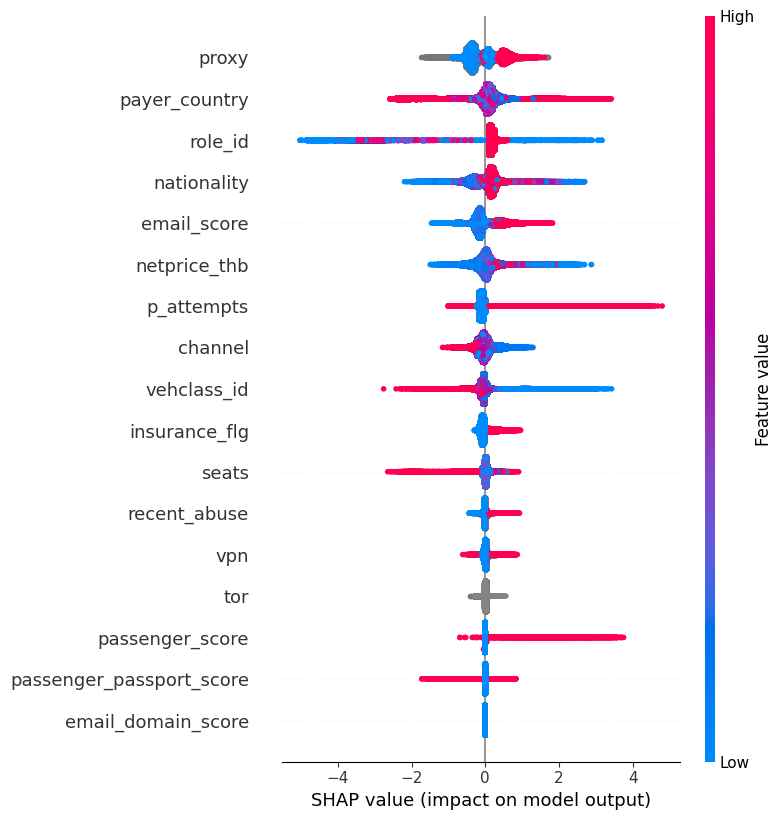

In [ ]:
def perform_shap_analysis(model_path, X_test, feature_names):
    model = joblib.load(model_path)
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names = feature_names)

model_path = '/content/drive/MyDrive/12GO/results/model/hgb.pkl'

feature_names = data.drop('isFraud', axis = 1).columns.tolist()
perform_shap_analysis(best_model, X_test, feature_names)

## Insights from the SHAP Analysis
SHAP identifies several high-impact features for fraud detection, particularly those related to security, transaction behavior, and user information. Proxy usage, VPN access, and TOR connections emerge as top indicators of fraudulent activities, highlighting the importance of monitoring anonymized networks. Transactions made through proxies or TOR tend to have higher SHAP values, pushing the prediction towards fraud detection, reinforcing the need for real-time IP tracking and reputation-based access controls. Additionally, email domain score, payer country, and net price (THB) play a significant role. Fraudulent transactions are often associated with low-reputation email domains and high transaction values, suggesting that email validation systems and transaction amount thresholds should be strengthened. Furthermore, the number of payment attempts is a critical fraud indicator, as fraudulent users frequently attempt multiple payment methods upon initial rejection.

In addition, the alignment between univariate analysis <code>01_exploration.ipynb</code> and SHAP findings reinforces the importance of incorporating security signals, email reputation, transaction behaviors, and user role-based risk factors in 12GO's fraud prevention model.

## Strategic Actions for Fraud Mitigation
Our results provide actionable intelligence for optimizing 12GO's fraud detection system. Enhancing risk-based authentication, blocking high-risk IPs, and enforcing stricter verification on high-value transactions are key steps toward mitigating fraudulent activities. By integrating these findings into an adaptive fraud prevention framework, 12GO can minimize financial losses, protect legitimate customers, and ensure a secure booking experience.